In [96]:
#required packages
import pandas as pd
import geopandas as gpd
#read in the geospatial data for the statistical sectors of Belgium
gdf = gpd.read_file("statistical_sectors.shp")

## Leuven Statistical Sectors


In [76]:
from pyproj import CRS
gdf
print("Current CRS:", gdf.crs)
gdf = gdf.to_crs(epsg=4326)

Current CRS: EPSG:3812


<Axes: >

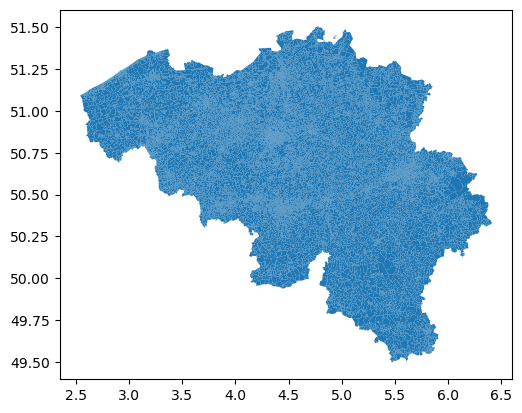

In [77]:
# plot of statistical sectors of Belgium
gdf.plot()

In [15]:
## ONLY IF WORKING WITH GEOJSON
#change of index to that defined by the first column
# gdf=gdf.set_index("ogc_fid")

KeyError: "None of ['ogc_fid'] are in the columns"

In [78]:
# view names of all columns in the data frame
print(gdf.columns.tolist())

['CS01012022', 'T_SEC_NL', 'T_SEC_FR', 'T_SEC_DE', 'C_NIS7', 'C_NIS6', 'T_NIS6_NL', 'T_NIS6_FR', 'MUN_DISTR', 'CNIS5_2022', 'T_MUN_NL', 'T_MUN_FR', 'T_MUN_DE', 'CNIS_ARRD_', 'T_ARRD_NL', 'T_ARRD_FR', 'T_ARRD_DE', 'CNIS_PROVI', 'T_PROVI_NL', 'T_PROVI_FR', 'T_PROVI_DE', 'CNIS_REGIO', 'T_REGIO_NL', 'T_REGIO_FR', 'T_REGIO_DE', 'C_COUNTRY', 'NUTS1_2021', 'NUTS2_2021', 'NUTS3_2021', 'M_AREA_HA', 'M_PERI_M', 'Shape_Leng', 'Shape_Area', 'geometry']


In [79]:
# drop unnecessary multilingual labels
gdf_wanted_columns = ["CS01012022","T_SEC_NL", "T_NIS6_NL", "T_MUN_NL", 
                                    "T_ARRD_NL", "T_PROVI_NL", "T_REGIO_NL", 
                                    "C_COUNTRY", 'M_AREA_HA', 'geometry']

gdf_nl = gdf[gdf_wanted_columns]

In [80]:
# subsetting by all statistical sectors in the municipality of Leuven
gdf_leuven=gdf_nl[gdf_nl["T_MUN_NL"]=="Leuven"]

In [81]:
# number of instances in the different sub-municipalities which Leuven is comprised of
gdf_leuven["T_NIS6_NL"].value_counts()

T_NIS6_NL
LEUVEN                            37
KESSEL-LO                         29
HEVERLEE + DEEL VAN BLANDEN       25
WILSELE                           17
DEEL KORBEEK-LO +DEEL HAASRODE     7
DEEL HERENT                        3
Name: count, dtype: int64

<Axes: >

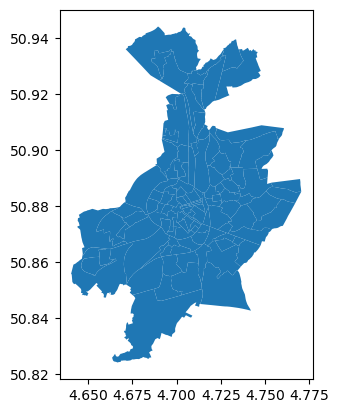

In [82]:
# plot of statistical sector in leuven municipaility
gdf_leuven.plot()

In [107]:
# reading in statistical sector data which contains populations counts
pop_df = pd.read_csv("statistical_sector_data.csv")
# selecting only the useful columns
pop_df=pop_df[["CD_SECTOR", "TOTAL", "TX_DESCR_SECTOR_NL", "TX_DESCR_NL"]]
# subsetting for sectors in Leuven municipality
pop_df=pop_df[pop_df["TX_DESCR_NL"]=="Leuven"]
# dropping incidence of residents whose sector was unknown
pop_df=pop_df[pop_df["TX_DESCR_SECTOR_NL"]!="NIET TE LOKALISEREN IN EEN SECTOR"]
pop_df

,CD_SECTOR,TOTAL,TX_DESCR_SECTOR_NL,TX_DESCR_NL
4180,24062A00-,769,LEUVEN-CENTRUM,Leuven
4181,24062A01-,828,LEI - VISMARKT,Leuven
4182,24062A02-,359,LEUVEN STADSPARK,Leuven
4183,24062A03-,708,DAMIAANPLEIN,Leuven
4184,24062A04-,333,LEUVEN KLINIEK -O.L.VROUW-KERK,Leuven
...,...,...,...,...
4293,24062E774,165,HAASRODE INDUSTRIEZONE,Leuven
4294,24062E790,291,DEN DUIVEL,Leuven
4295,24062F40-,2506,WIJGMAAL-KERN,Leuven
4296,24062F412,570,WIJVELD,Leuven


In [84]:
# merge dataframe with population info with the geodataframe
gdf_pop_leuven = pd.merge(right=pop_df,left=gdf_leuven, right_on="CD_SECTOR", left_on="CS01012022")
# drop unwanted columns
gdf_pop_leuven = gdf_pop_leuven.drop(["TX_DESCR_SECTOR_NL", "TX_DESCR_NL", "CS01012022"], axis = 1)
# calculating population density for visualisation purposes
gdf_pop_leuven["pop_density"] = gdf_pop_leuven["TOTAL"]/gdf_pop_leuven["M_AREA_HA"]

In [85]:
# cool interactive map which displays the sectors and their info, coloured by population density
gdf_pop_leuven.explore("pop_density", legend=False)

## Creating a random scattering of First Responders

In [86]:
# calculating total population of leuven
leuven_pop = sum(gdf_pop_leuven["TOTAL"])
# calculating proportion of the population residing in each sector
gdf_pop_leuven["pop_proportion"] = gdf_pop_leuven["TOTAL"]/leuven_pop
gdf_pop_leuven["pop_proportion"]

0      0.007478
1      0.008051
2      0.003491
3      0.006885
4      0.003238
         ...   
113    0.001604
114    0.002830
115    0.024368
116    0.005543
117    0.006642
Name: pop_proportion, Length: 118, dtype: float64

In [87]:
# function which takes as input the desired proporiton of the population who will 
# act as first responders, and outputs a realistic number of FRs in each sector
def fr_pop_proportion(x):
    gdf_pop_leuven["fr_per_sector"]=round(gdf_pop_leuven["pop_proportion"]*x*leuven_pop).astype(int)
    return gdf_pop_leuven["fr_per_sector"]

In [88]:
# taking 0.5% of the population to be enrolled in our FR program
fr_pop_proportion(0.005)
# ensuring at least one first responder per sector
# fr

0       4
1       4
2       2
3       4
4       2
       ..
113     1
114     1
115    13
116     3
117     3
Name: fr_per_sector, Length: 118, dtype: int32

In [89]:
# manipulating the output of our function so that it may be used to generate the
# random points (first responders) for each sector
fr_array = gdf_pop_leuven["fr_per_sector"].to_numpy()
# generating random points
gdf_pop_leuven["fr_loc"] = gdf_pop_leuven.sample_points(size=fr_array, method="uniform", rng=1)
# plotting the sectors and random points on an interactive map
m = gdf_pop_leuven.explore()
gdf_pop_leuven["fr_loc"].explore(m=m, color='red')

C:\Users\Dillon\anaconda3\Lib\site-packages\geopandas\tools\_random.py:83: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  return GeoSeries(candidates[:size]).unary_union
C:\Users\Dillon\anaconda3\Lib\site-packages\geopandas\tools\_random.py:83: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  return GeoSeries(candidates[:size]).unary_union
C:\Users\Dillon\anaconda3\Lib\site-packages\geopandas\tools\_random.py:83: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  return GeoSeries(candidates[:size]).unary_union
C:\Users\Dillon\anaconda3\Lib\site-packages\geopandas\tools\_random.py:83: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLE

In [94]:
# getting each fr loc as a seperate point
frs = gdf_pop_leuven["fr_loc"].explode()

C:\Users\Dillon\AppData\Local\Temp\ipykernel_14456\2633862630.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  frs = gdf_pop_leuven["fr_loc"].explode()


In [95]:
# getting the fr locs in coordinate form, in order to calculate the taxicab metric
fr_coords=frs.get_coordinates()

# example of taxicab metric calculation
fr_coords.iloc[1]-fr_coords.iloc[0]

x    0.000191
y    0.000566
dtype: float64